In [283]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [284]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')
sources_path = Path("/content/drive/MyDrive/dl-samples") 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [285]:
loader = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader(str(sources_path / "style.jpg"))
content_img = image_loader(str(sources_path / "orig.jpg"))

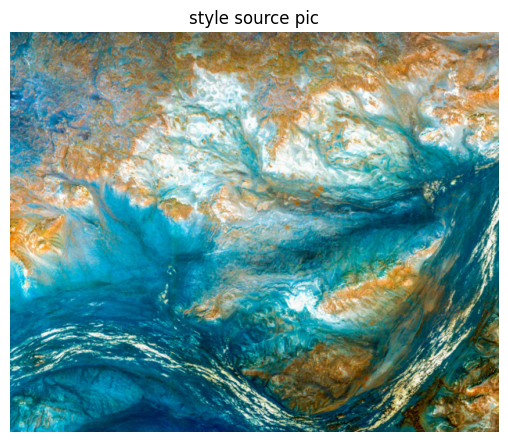

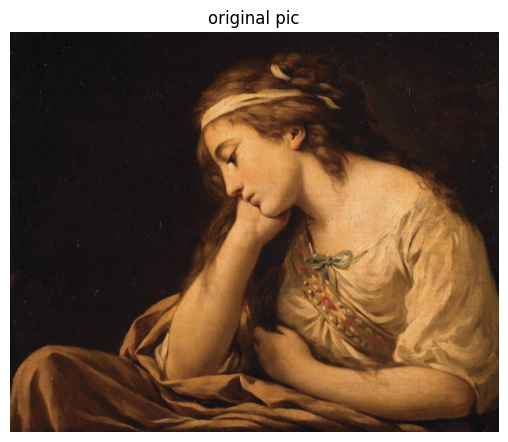

In [286]:
import cv2
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

plt.style.use('default')
pltloader = transforms.ToPILImage()

def pyplot(func):
    def make_pyplot_context(*args, **kwargs):
        plt.figure(figsize=(8, 4))
        ax = plt.axes([0,0,1,1], frameon=False)
        ax.set_axis_off()
        return func(*args, **kwargs)
    return make_pyplot_context

@pyplot
def show_img(tensor, title = None):
    img = tensor.clone().detach()
    img = img.squeeze(0)
    img = pltloader(img)
    plt.imshow(img)
    if title is not None:
        plt.title(title)

show_img(style_img, title='style source pic')
show_img(content_img, title='original pic')

In [287]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self.gram_M(target_feature).detach()
    
    def gram_M(self, input):
        a, b, c, d = input.size()
        features = input.reshape(a * b, c * d)
        mat = torch.matmul(features, torch.transpose(features, 0, 1))
        return mat.div(a * b * c * d)

    def forward(self, input):
        G = self.gram_M(input)
        self.loss = F.mse_loss(G, self.target)
        return input

class InitNorm(nn.Module):
    def __init__(self, mean, std):
        super(InitNorm, self).__init__()
        self.mean = torch.tensor(mean).reshape(-1, 1, 1)
        self.std = torch.tensor(std).reshape(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [288]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

norm_mean_default = torch.tensor([0.485, 0.456, 0.406]).to(device)
norm_std_default = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [289]:
def get_losses(cnn, style_img, content_img,
               norm_mean=norm_mean_default, 
               norm_std=norm_std_default,
               content_layers=content_layers_default,
               style_layers=style_layers_default):
    content_losses, style_losses = [], []

    normalization = InitNorm(norm_mean, norm_std).to(device)
    model = nn.Sequential(normalization)

    conv_counter = 0 
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            conv_counter += 1
            name = 'conv_{}'.format(conv_counter)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(conv_counter)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(conv_counter)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(conv_counter)

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(conv_counter), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(conv_counter), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

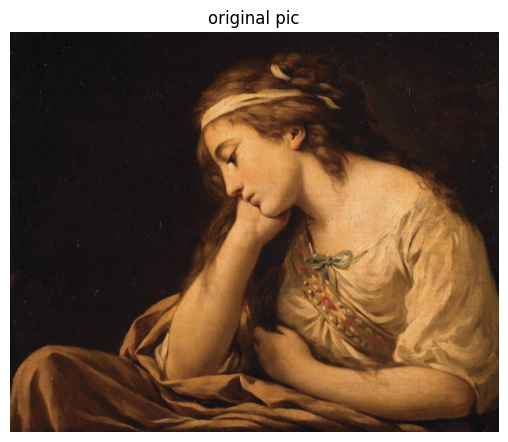

In [290]:
input_img = content_img.clone()
show_img(input_img, title='original pic')

In [291]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [292]:
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):

    model, style_losses, content_losses = get_losses(cnn, style_img, content_img)

    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    iter = 0
    while iter <= num_steps:

        def closure():
            nonlocal iter
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score, content_score = 0, 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            iter += 1
            if iter % 50 == 0:
                print(f'Iteration {iter} \t| Style Loss : {style_score.item()} \t| Content Loss: {content_score.item()}')

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration 50 	| Style Loss : 97.7891845703125 	| Content Loss: 25.730863571166992
Iteration 100 	| Style Loss : 22.621973037719727 	| Content Loss: 23.38999366760254
Iteration 150 	| Style Loss : 12.480661392211914 	| Content Loss: 20.530330657958984
Iteration 200 	| Style Loss : 8.221785545349121 	| Content Loss: 18.296634674072266
Iteration 250 	| Style Loss : 5.744658470153809 	| Content Loss: 16.55817413330078
Iteration 300 	| Style Loss : 3.6357953548431396 	| Content Loss: 15.319621086120605


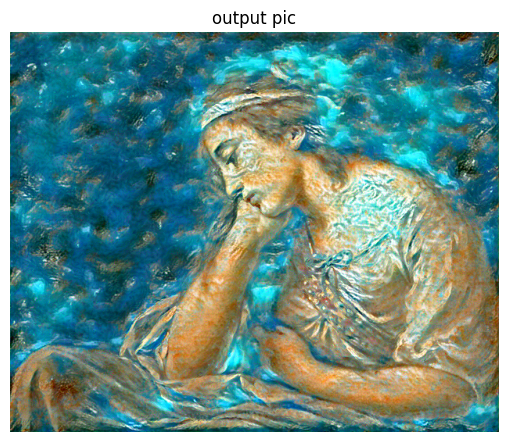

In [293]:
output = run_style_transfer(cnn, content_img, style_img, input_img)
show_img(output, title='output pic')